In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf




In [4]:
!apt install ffmpeg libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libasound2-dev' instead of 'libasound-dev'
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19

In [ ]:
!cd /content
!ls
!unzip a.zip

drive  sample_data
unzip:  cannot find or open a.zip, a.zip.zip or a.zip.ZIP.


In [ ]:
!pwd

for dirname, _, filenames in os.walk('/content'):
  #print(filenames)
  for filename in filenames:
    #if"Data.json" in filename:
    # print(os.path.join(dirname, filename))
    pass


/content


In [ ]:
!ls sample_data/*

sample_data/anscombe.json		  sample_data/mnist_test.csv
sample_data/california_housing_test.csv   sample_data/mnist_train_small.csv
sample_data/california_housing_train.csv  sample_data/README.md


In [2]:
# Dataset location
SOURCE_PATH = '/content/drive/MyDrive/Sample/genres_original'

# Path to labels and processed data file, json format.
JSON_PATH = '/content/drive/MyDrive/Sample/data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger. 
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [5]:
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            print("file", file)
            # return
            if not file in ['hiphop.00000.wav', 'jazz.00054.wav']:
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Let's write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [6]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [7]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [8]:
def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [9]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))


In [10]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

file pop.00005.wav
file pop.00002.wav
file pop.00004.wav
file pop.00007.wav
file pop.00008.wav
file pop.00000.wav
file pop.00001.wav
file pop.00006.wav
file pop.00009.wav
file pop.00003.wav
file pop.00020.wav
file pop.00010.wav
file pop.00021.wav
file pop.00022.wav
file pop.00017.wav
file pop.00013.wav
file pop.00018.wav
file pop.00012.wav
file pop.00016.wav
file pop.00014.wav
file pop.00011.wav
file pop.00019.wav
file pop.00015.wav
file pop.00027.wav
file pop.00028.wav
file pop.00023.wav
file pop.00032.wav
file pop.00024.wav
file pop.00033.wav
file pop.00034.wav
file pop.00037.wav
file pop.00036.wav
file pop.00035.wav
file pop.00026.wav
file pop.00025.wav
file pop.00029.wav
file pop.00031.wav
file pop.00030.wav
file pop.00045.wav
file pop.00048.wav
file pop.00038.wav
file pop.00044.wav
file pop.00043.wav
file pop.00050.wav
file pop.00046.wav
file pop.00040.wav
file pop.00051.wav
file pop.00041.wav
file pop.00047.wav
file pop.00042.wav
file pop.00049.wav
file pop.00039.wav
file pop.000

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
200/200 [==============================] - 16s 74ms/step - loss: 1.5878 - acc: 0.4431 - val_loss: 1.5734 - val_acc: 0.4319
Epoch 2/30
200/200 [==============================] - 15s 73ms/step - loss: 1.1831 - acc: 0.5735 - val_loss: 1.0360 - val_acc: 0.6303
Epoch 3/30
200/200 [==============================] - 15s 76ms/step - loss: 1.0184 - acc: 0.6366 - val_loss: 0.9257 - val_acc: 0.6678
Epoch 4/30
200/200 [==============================] - 15s 74ms/step - loss: 0.8744 - acc: 0.6902 - val_loss: 0.9318 - val_acc: 0.6869
Epoch 5/30
200/200 [==============================] - 15s 73ms/step - loss: 0.7890 - acc: 0.7186 - val_loss: 1.2601 - val_acc: 0.6042
Epoch 6/30
200/200 [==============================] - 16s 78ms/step - loss: 0.7384 - acc: 0.7453 - val_loss: 1.6498 - val_acc: 0.5145
Epoch 7/30
200/200 [==============================] - 15s 76ms/step - loss: 0.6775 - acc: 0.7589 - val_loss: 0.9824 - val_acc: 0.6784
Epoch 8/30
200/200 [==============================] - 15s 76ms

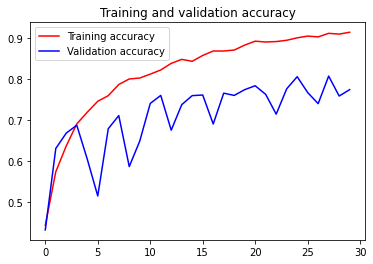

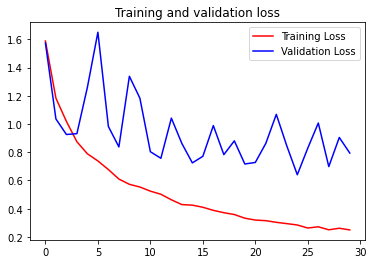

50/50 [==============================] - 1s 18ms/step

---Now testing the model for one audio file---
The model predicts: blues, and ground truth is: blues.



In [11]:
if __name__ == "__main__":

    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    inputs, targets = load_data(json_path=JSON_PATH)
    
    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    #Training the model.
    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=30,
                        batch_size=32
                        )

    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, Xtest, ytest, 24)